# Data Prepocessing

The following steps are taken to preprocess the data.

- **1. Shapefiles**
    - Load shapefiles (stream gages, precipitation stations, boundaries).
    - Clean, simplify, and reproject shapefiles.
    - Clip and mask data based on region of interest.
    - Create Thiessen Polygons for precipitation stations for taking into account the spatial distibution of rain.
    - Extract relevant features (e.g., drainage area, station location).

- **2. Raster Data**
    - Load raster data (elevation, land cover).
    - Resample and align raster data layers.
    - Clip and mask data based on region of interest.
    - Extract key features (e.g., elevation, impervious surface).
    - Delineate watershed boundaries and extract watershed geomorphological characteristics
    - Normalize raster values.

- **3. Tabular Data**
    - Load time-series data (streamflow, precipitation).
    - Handle missing values and fill gaps.
    - Standardize time formats and indices.
    - Identify and remove outliers.
    - Resample and aggregate data to a uniform time step.
    - Create new features (e.g., moving averages).

- **4. Data Integration**
    - Spatially join shapefiles with raster and tabular data.
    - Merge time-series data based on time and location.
    - Aggregate raster features for each station or gage.

- **5. Selection of Storm Events**

- **6. Clark's parameter optmization**
    - Optmize Clark's parameters for the selected events
    - Spatially join the optmized parameters with shapefile data.

- **5. Machine Learning Preparation**
    - Scale and normalize features.
    - Split dataset into training and testing sets.
    - Encode categorical features.
    - Select most relevant features for training.


In [114]:
# Import modules
from pathlib import Path
import time
import sys
import geopandas as gpd
from shapely.geometry import Point
from plotnine import *
import warnings
from dotenv import load_dotenv
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

In [96]:
# File paths
project_base_path = Path.cwd().parent.parent

In [97]:
# Add 'src' to system path
sys.path.append(str(project_base_path / 'src'))

# Import modules
from preprocessing.thiessenPolygons import derive_thiessen_polygons

# Ignore warnings
warnings.filterwarnings('ignore')

In [98]:
# Load tokens
load_dotenv(project_base_path / '.env')

NOAA_API_TOKEN = os.getenv('NOAA_API_TOKEN')


## 1. Shapefiles

### 1.1 Load shapefiles

In [111]:
# File paths
shapefiles_base_path = project_base_path / 'data'/ 'geo'/ 'shp'

dam_location_path = shapefiles_base_path / 'dams_location' / 'Dams.shp'

precip_stations_v1_path = shapefiles_base_path / 'precipitation_stations' / 'precip_15.kmz'
precip_stations_v2_path = project_base_path /  'data'/ 'geo'/ 'json' / 'ppt_stations_inventory.json'

streamgage_stations_path = shapefiles_base_path / 'streamgage_stations' / 'realstx.shp'

us_county_path = shapefiles_base_path / 'us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'us_state' / 'tl_2024_us_state.shp'

world_utm_zones_path = shapefiles_base_path.parent / 'json' / 'World_UTM_Grid.geojson'

upper_hudson_basin_path = shapefiles_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
upper_hudson_basin_1km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_1km_buffer' / 'upper_hudson_basin_1km_buffer.shp'
upper_hudson_basin_5km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_5km_buffer' / 'upper_hudson_basin_5km_buffer.shp'
upper_hudson_basin_10km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_10km_buffer' / 'upper_hudson_basin_10km_buffer.shp'
upper_hudson_basin_30km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_30km_buffer' / 'upper_hudson_basin_30km_buffer.shp'

In [113]:
# Read shapefiles
try:
    start_time = time.time()

    precip_stations_v1 = gpd.read_file(precip_stations_v1_path)
    precip_stations_v2 = pd.read_json(precip_stations_v2_path)

    streamgage_stations = gpd.read_file(streamgage_stations_path)

    dam_location = gpd.read_file(dam_location_path)

    us_county = gpd.read_file(us_county_path)
    us_state = gpd.read_file(us_state_path)

    world_utm_zones = gpd.read_file(world_utm_zones_path)

    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    upper_hudson_basin_1km_buffer = gpd.read_file(upper_hudson_basin_1km_buffer_path)
    upper_hudson_basin_5km_buffer = gpd.read_file(upper_hudson_basin_5km_buffer_path)
    upper_hudson_basin_10km_buffer = gpd.read_file(upper_hudson_basin_10km_buffer_path)
    upper_hudson_basin_30km_buffer = gpd.read_file(upper_hudson_basin_30km_buffer_path)

    end_time = time.time()

    print('Shapefiles read successfully. Time elapsed:', round(end_time - start_time, 2), 'seconds')
except Exception as err:
    print('Error reading shapefiles:', err)

Shapefiles read successfully. Time elapsed: 9.98 seconds


### 1.2. Clean and Prepare Datasets
#### 1.2.1. Precipitation Stations

The Precipitation Station location covers the entire united states, is in kmz format and the ID station is encoded in HTML code, and has other irrelevant attributes. The following steps will be taken to clean and prepare the dataset:

- **1. Clip the data to have precipitation stations only in area of interest.**
- **2. Decode the HTML code to extract the station ID and elevation.**
- **3. Drop irrelevant attributes.**
- **4. Add begin and end historical data info.**
- **5. Reproject.**
- **6. Tag Overlapping precipitaion stations**
- **7. Generate Thyessen Polygons to account for spatial distribution of rain.**
- **8. Export station ID and relevant attributes in JSON format.** That document will be used later to download precipitation data.


**1.2.1.1. Clip the Data**

For the mask, we will use the study region + 30km buffer to make ensure that none of possible precipitation station is left outside. We will define later which station to use. 


In [115]:
# Convert to geopandas object
nad83_epsg = 'EPSG:4269'
precip_stations_v2['geometry'] = precip_stations_v2.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
precip_stations_v2 = gpd.GeoDataFrame(data=precip_stations_v2, crs=nad83_epsg)

# Clip the data
precip_stations_v1_clipped = gpd.clip(precip_stations_v1.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)
precip_stations_v2_clipped = gpd.clip(precip_stations_v2.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)

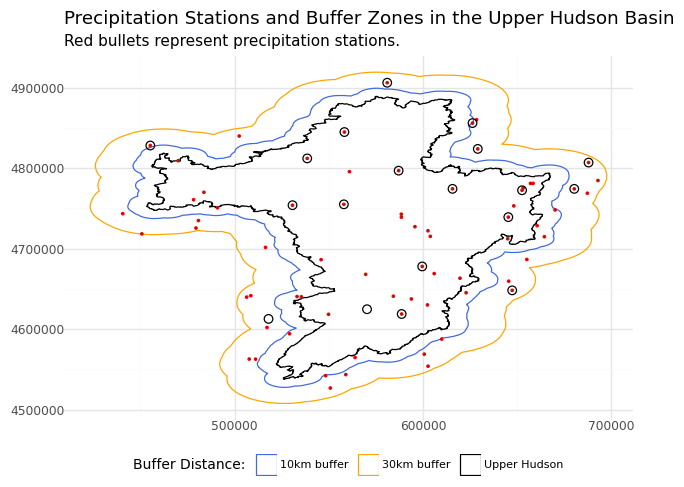

In [119]:
geom_merged = pd.concat(
    [
        upper_hudson_basin.to_crs(precip_stations_v1_clipped.crs)[['geometry']].assign(LAYER='Upper Hudson'),
        upper_hudson_basin_10km_buffer[['geometry']].assign(LAYER='10km buffer'),
        upper_hudson_basin_30km_buffer[['geometry']].assign(LAYER='30km buffer')
    ]
)

precip_station_map = (
    ggplot(geom_merged)
    + geom_map(
        mapping=aes(geometry='geometry', color = 'LAYER'),
        fill = None
    )
    + geom_map(
        data = precip_stations_v1_clipped[['geometry']],
        mapping=aes(gemetry='geometry'),
        color='red'
    )
    + geom_map(
        data = precip_stations_v2_clipped[['geometry']],
        mapping=aes(gemetry='geometry'),
        color='black',
        fill = None,
        size = 3
    )
    + labs(title='Precipitation Stations and Buffer Zones in the Upper Hudson Basin',
           subtitle= 'Red bullets represent precipitation stations.')

    # Manually define colors
    + scale_color_manual(
        name='Buffer Distance:',
        values={
            'Upper Hudson': 'black',
            '10km buffer': 'royalblue',
            '30km buffer': 'orange'
            }
    )
    + coord_cartesian()
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position='bottom'
    )
)
precip_station_map.draw()


**1.2.1.2. Decode HTML**

The station ID and elevation attributes, which we want to keep, are encoded in HTML tags. We will extract those attributes and add it to a new column called `precip_station_id`  and `precip_station_elev` respectively. Precipitation elevation is in meters. Below is an example of precipitation station description encoded as html:`

In [108]:
print(precip_stations_v1_clipped['description'].iloc[0])


    
    <table>
    <tr><td>ID: COOP:280907</td></tr>
    <tr><td>COUNTRY: United States</td></tr>
    <tr><td>LATITUDE: 40.89174</td></tr>
    <tr><td>LONGITUDE: -74.39635</td></tr>
    <tr><td>ELEVATION: 85.3 m.</td></tr>
    <tr><td></td></tr>
    </table>
    <table>
    <tr><td><form action="https://www.ncdc.noaa.gov/cdo-web/mapReview" method="post">
        <input type="hidden" name="_dataSet" value="PRECIP_15"/>
        <input type="hidden" name="_stationId" value="COOP:280907"/>
        <input type="submit" value="Access Station Data"/>
    </form></td></tr>
    </table> 
  


In [122]:
precip_stations_v2_clipped.shape

(19, 16)

In [11]:
# Define function to extract precipitation station id and elevation attributes
def decode_precipt_station_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    id = soup.find('td').text.split(': ')[1].strip()
    elevation = soup.find_all('td')[4].text.split(': ')[1]
    elevation_float = float(elevation.split()[0])

    return pd.Series([id, elevation_float])

# Extract attributes
try:
    precip_stations_clipped[['precip_station_id', 'precip_station_elev']] = precip_stations_clipped['description'].apply(decode_precipt_station_html)
    print('Attribute successfully extracted.')
except Exception as err:
    print(f'Failed to extract attibutes: {err}')

Attribute successfully extracted.


**1.2.1.3. Drop irrelevant attributes**

Below is shows all of the attributes in our precipitation station layer. The relevant attributes are: `Name`, `begin` (empty, but we will get this data later), `end` (empty, but we will get this data later), `geometry`, `precip_station_id` and `precip_station_elev`.

In [12]:
precip_stations_clipped.head()

,id,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry,precip_station_id,precip_station_elev
30,31,"BOONTON 1 SE, NJ US",\n \n <table>\n <tr><td>ID: COOP:2809...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (550850.97 4526914.624 0),COOP:280907,85.3
1,2,"CHARLOTTEBURG RESERVOIR, NJ US",\n \n <table>\n <tr><td>ID: COOP:2815...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (548355.898 4542242.25 0),COOP:281582,237.1
2,3,"WANAQUE RAYMOND DAM, NJ US",\n \n <table>\n <tr><td>ID: COOP:2891...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (559071.261 4543608.511 0),COOP:289187,71.9
225,226,"PLEASANTVILLE, NY US",\n \n <table>\n <tr><td>ID: COOP:3066...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (602750.905 4554064.92 0),COOP:306674,97.5
438,439,"DINGMANS FERRY, PA US",\n \n <table>\n <tr><td>ID: COOP:3621...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (511176.454 4562818.525 0),COOP:362160,131.1


In [ ]:
# Remove irrelevant attributes
keep_attributes = ['Name', 'begin','end', 'geometry', 'precip_station_id', 'precip_station_elev']
precip_stations_clipped = precip_stations_v1_clipped[keep_attributes]
precip_stations_clipped.head()

KeyError: "['precip_station_id', 'precip_station_elev'] not in index"

**1.2.1.4. Add relevant attributes**

The downloaded precipitation stations location layer does not have `begin` and `end`info on its attributes. This info is import to dowloading ([see this notebook](../data%20download/data_download.ipynb)) the historical precipitation data. We retrieve this info from NOOA API. [Documentation available here](https://www.ncdc.noaa.gov/cdo-web/webservices/v2). We also need to identify if the station is either within huson basin, 10km buffer or 30km buffer.

**Begin** and **End** dates:

In [14]:
def get_precip_station_operational_dates(station_id, token=NOAA_API_TOKEN):
    """
    Retrieves the operational begin and end dates for a given precipitation station.

    Parameters:
        station_id (str): The ID of the precipitation station.
        token (str): NOAA API token.

    Returns:
        dict: Contains 'begin', 'end', and 'n_requests'.
    """
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/'
    headers = {"Token": token}
    endpoint = 'datasets'
    parameters = {'stationid': station_id}
    max_retries = 4
    count = 0

    for attempt in range(1, max_retries + 1):
        count += 1
        try:
            response = requests.get(url=base_url + endpoint, headers=headers, params=parameters)
            response.raise_for_status()
            data = response.json()

            # Check if 'results' exists and is not empty
            if 'results' not in data or not data['results']:
                raise ValueError(f"No results found for station ID {station_id}")

            begin = data['results'][0].get('mindate')
            end = data['results'][0].get('maxdate')

            return {'begin': begin, 'end': end, 'n_requests': count}

        except (requests.exceptions.RequestException, ValueError) as err:
            print(f"Attempt {attempt} failed for station ID {station_id}: {err}")
            if attempt == max_retries:
                # Return only 'n_requests' to indicate failure
                return {'n_requests': count}
            time.sleep(1)  # Wait before retrying

    # In case the loop exits without returning (shouldn't happen)
    return {'n_requests': count}


In [48]:
overall_start_time = time.time()
# Add begin and end date to geodataframe 
failed_stations_id = []
request_count = 0
start_time = time.time()

for i, row in precip_stations_clipped.iterrows():
    print(f'Getting operational dates for station {row['precip_station_id']}', end= '\r')
    
    # Retrieving only for NaT values
    if row['begin'] is not pd.NaT or row['end'] is not pd.NaT:
        continue

    current_time = time.time()
    elapsed_time = current_time - start_time

    # Reset the counter and timer every second
    if elapsed_time > 1:
        request_count = 0
        start_time = current_time

    if request_count >= 4:
        time.sleep(1)
        request_count = 0
        start_time = time.time()

    try:
        dates = get_precip_station_operational_dates(station_id=row['precip_station_id'])
        request_count += dates.get('n_requests')

    except Exception as err:
        failed_stations_id.append(row['precip_station_id'])
        print(f"Request for data failed for station ID {row['precip_station_id']}: {err}")
        request_count += dates.get('n_requests')
        continue

    if dates:
        try:
            precip_stations_clipped.at[i, 'begin'] = dates.get('begin')
            precip_stations_clipped.at[i, 'end'] = dates.get('end')
        except Exception as err:
            failed_stations_id.append(row['precip_station_id'])
            print(f"Failed to get dates for station ID {row['precip_station_id']}: {err}")
            continue

overall_start_time_str = f"Elapsed time: {round(time.time()-overall_start_time, 2)} seconds."
if failed_stations_id:
    print(f"Ended getting data. Failed for the following stations: {', '.join(failed_stations_id)}. " + overall_start_time_str)
else:
    print(f"Successfully retrieved all begin and end dates. " + overall_start_time_str)

Attempt 1 failed for station ID COOP:301987: 503 Server Error: Service Unavailable for url: https://www.ncei.noaa.gov/cdo-web/api/v2/datasets?stationid=COOP%3A301987
Successfully retrieved all begin and end dates. Elapsed time: 74.66 seconds.


**1.2.1.5. Reproject**

When working with geospatial data in the Upper Hudson River Basin, selecting an appropriate map projection is essential to ensure the accuracy of spatial attribute calculations, such as area and perimeter. For this study, the **NAD83 datum** has been chosen as it is widely used for regional geospatial analysis within the United States. Specifically, we will utilize the **NAD83 / UTM Zone 18N (EPSG:26918)** projection, which is well-suited for the geographic extent of the Hudson River Basin.

The UTM Zone 18N projection minimizes distortions in distance and area measurements by dividing the Earth into zones optimized for small regions. This makes it ideal for hydrological studies and sub-basin analyses, where precision is critical. The projection's use of meters as the measurement unit simplifies calculations of spatial attributes, ensuring consistency and ease of interpretation.

For larger-scale or cross-basin analyses, equal-area projections such as **Albers Equal Area (EPSG:5070)** or **Lambert Conformal Conic (EPSG:102009)** can be considered. However, for this focused study on sub-basins within the Upper Hudson River region, the selected UTM projection provides the most practical and accurate framework.


In [15]:
# Filter UTM bounds to be within the bounds of the upper hudson basin
upper_hudson_basin_bounds = list(upper_hudson_basin.total_bounds)

utm_bounds = world_utm_zones.bounds

utm_intersecting_bounds = (
    (utm_bounds['minx'] < upper_hudson_basin_bounds[2]) &  # UTM left < Basin right
    (utm_bounds['maxx'] > upper_hudson_basin_bounds[0]) &  # UTM right > Basin left
    (utm_bounds['miny'] < upper_hudson_basin_bounds[3]) &  # UTM bottom < Basin top
    (utm_bounds['maxy'] > upper_hudson_basin_bounds[1])    # UTM top > Basin bottom
)
world_utm_zones_filtered = world_utm_zones[utm_intersecting_bounds]

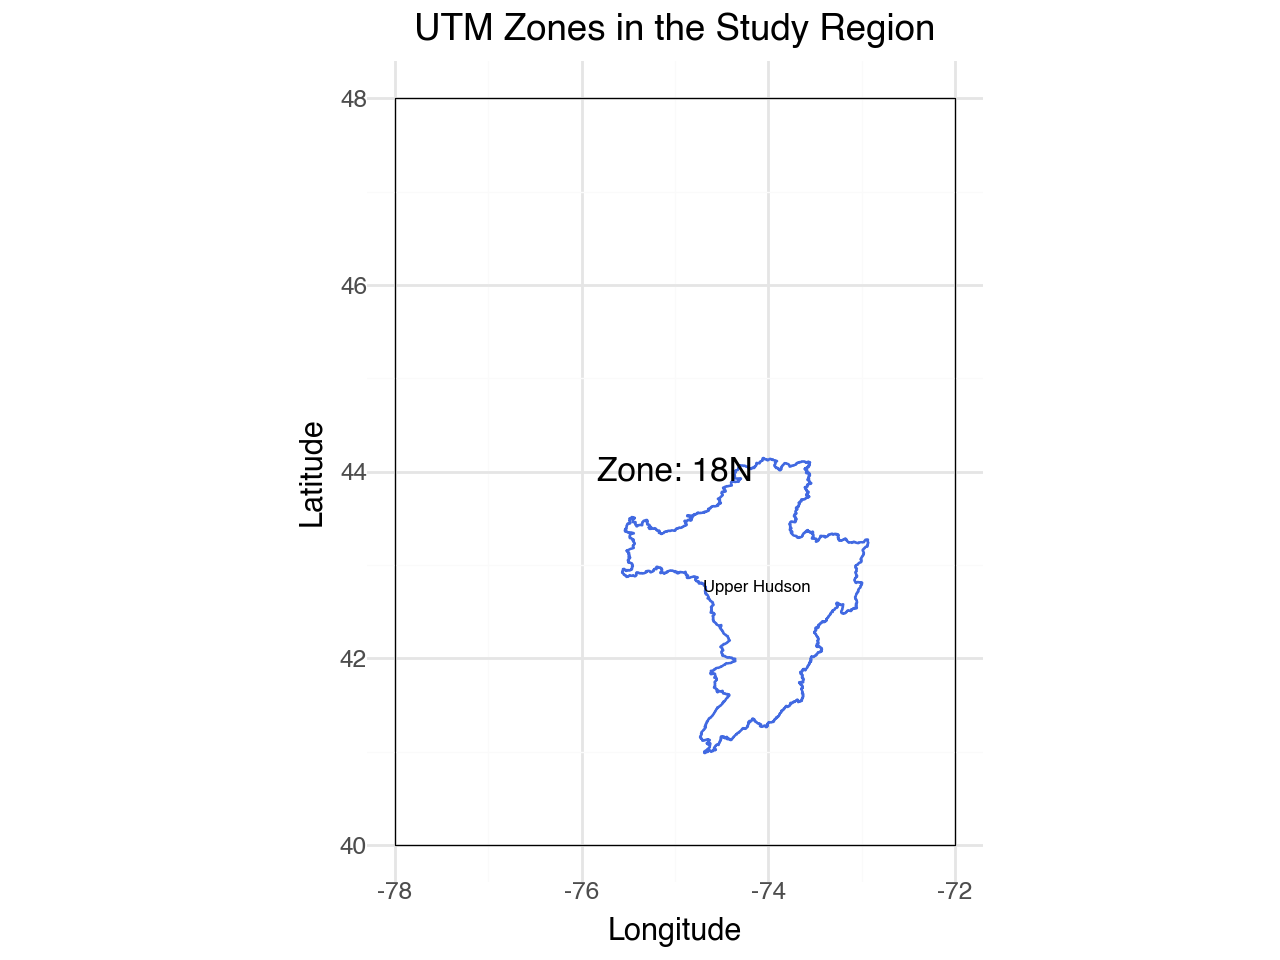

In [16]:
# Define centroid for text legend
world_utm_zones_filtered['lon'] = world_utm_zones_filtered.centroid.x
world_utm_zones_filtered['lat'] = world_utm_zones_filtered.centroid.y

world_utm_zones_filtered['ZONE_str'] = 'Zone: ' + world_utm_zones_filtered['ZONE'].astype(str)+'N'

# Map
utm_zones_map = (
    ggplot(upper_hudson_basin)
        + geom_map(
            mapping=aes(geometry="geometry"),
            inherit_aes=True, 
            color = 'royalblue',
            fill=None
        )
         + geom_text(
            mapping=aes(x="lon", y="lat", label="name"),
            size=6,
            color="black"
        )
        + geom_map(
            mapping=aes(geometry="geometry"),
            data=world_utm_zones_filtered,
            inherit_aes=False,
            color="black",
            size=0.25,
            fill = None
        )
        + geom_text(
            mapping=aes(x="lon", y="lat", label="ZONE_str"),
            size=12,
            color="black",
            data = world_utm_zones_filtered,
            inherit_aes=False
        )
        + coord_fixed()
        + theme_minimal()
        + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
        + labs(title="UTM Zones in the Study Region", x="Longitude", y="Latitude")
    
)
utm_zones_map
                 

In [17]:
target_crs = "EPSG:26918"  # UTM Zone 18N

# Reproject precipitation station and basin layers
precip_stations_clipped = precip_stations_clipped.to_crs(target_crs)
upper_hudson_basin = upper_hudson_basin.to_crs(target_crs)
upper_hudson_basin_10km_buffer = upper_hudson_basin_10km_buffer.to_crs(target_crs)
upper_hudson_basin_30km_buffer = upper_hudson_basin_30km_buffer.to_crs(target_crs)


**1.2.1.5. Overlapping precipitaion stations**

Depending on the number of sations that fall outside the uppder hudson basin but whithin the limits of 10 or 30km buffer, we will keep stations outside the basin with the goal to increase our availble data.

In [18]:
precip_stations_clipped['within_basin'] = precip_stations_clipped.within(upper_hudson_basin.unary_union)
precip_stations_clipped['within_10kmbuffer'] = precip_stations_clipped.within(upper_hudson_basin_10km_buffer.unary_union)
precip_stations_clipped['within_30kmbuffer'] = precip_stations_clipped.within(upper_hudson_basin_30km_buffer.unary_union)

print(f'There are {sum(precip_stations_clipped['within_basin'])} stations within boundaries of basin.')
print(f'{sum(precip_stations_clipped['within_10kmbuffer'])- sum(precip_stations_clipped['within_basin'])} stations fall in 10km buffer.')
print(f'{sum(precip_stations_clipped['within_30kmbuffer'])- sum(precip_stations_clipped['within_10kmbuffer'])} stations fall in 30km buffer.')

There are 31 stations within boundaries of basin.
10 stations fall in 10km buffer.
29 stations fall in 30km buffer.


**1.2.1.6 Thiessen Polygons**

Thiessen polygons, also known as Voronoi polygons or Dirichlet tessellations, are a way to partition a plane into regions based on the distance to points in a specific subset of the plane. For each point, there is a corresponding polygon consisting of all points closer to that point than to any other.

On the context of this study we have several scattered points representing precipitation stations. A Thiessen polygon for a given station encompasses the area that is closer to that station than to any other point in the set. Visually, these polygons are constructed by drawing perpendicular bisectors between each pair of points. The intersections of these bisectors create the boundaries of the polygons.

Thiessen polygons are important tool for defining areas of influence for they provide a clear and unambiguous way to define the area of influence of each point. This is crucial in determining which weather station is most representative of a given location.

However, while simple to understand and implement, Thiessen polygons have limitations. They assume abrupt changes at polygon boundaries and don't account for factors like terrain or other spatial influences. Nontheless, they remain a valuable tool for spatial analysis.

In [ ]:
thiessen_polygons = derive_thiessen_polygons(gdf_points=precip_stations_clipped, clipping_gdf= upper_hudson_basin, preserve_attribute='precip_station_id')

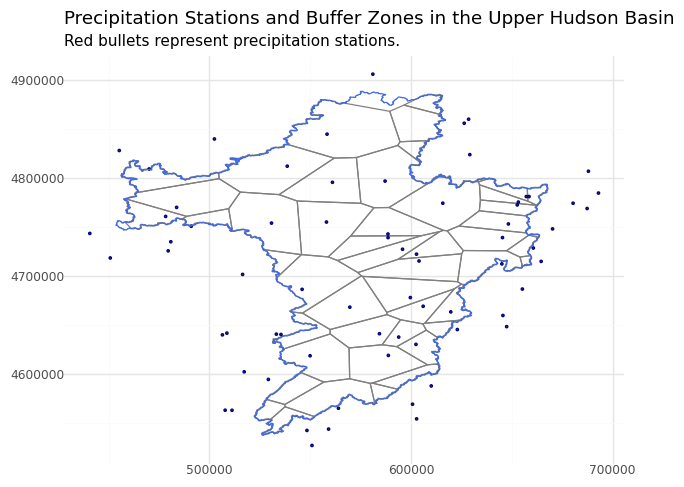

In [ ]:
thiessen_polygons['lat'] = thiessen_polygons.geometry.x
thiessen_polygons['lon'] = thiessen_polygons.geometry.y

thiessen_polygons_map = (
    ggplot(thiessen_polygons)
    + geom_map(
        mapping=aes(geometry='geometry'),
        fill = None,
        color = 'grey'
    )
    + geom_map(
        data = precip_stations_clipped[['geometry']],
        mapping=aes(gemetry='geometry'),
        color='darkblue'
    )
    + geom_map(
        data = upper_hudson_basin[['geometry']],
        mapping=aes(geometry='geometry'),
        color = 'royalblue',
        fill = None
    )
    + geom_text(
        data = thiessen_polygons
        mapping=aes(x = 'lat', y= 'lon')
    )
    + labs(title='Precipitation Stations and Buffer Zones in the Upper Hudson Basin',
           subtitle= 'Red bullets represent precipitation stations.')

    # Manually define colors
    + coord_cartesian()
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position='bottom'
    )
)

thiessen_polygons_map.draw()

In [ ]:
parameters2 = {'stationid':'COOP:267369',
               'datasetid':'PRECIP_15',
               'startdate':'2012-10-31',
               'enddate':'2012-12-31'}
response2 = requests.get(url=base_url + 'data', headers=headers, params=parameters2)
response2.json()